In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [2]:
# Mainline Unreduced Flow Parameters
v_f = 65 # mph
k_c = 60 # vehicles per mile
k_m = 240 # vehicles per mile
q_max = v_f*k_c # vph
w_c = q_max/(k_m-k_c)


In [3]:
# Reduced Flow Segment Parameters
k_c_2lane = 40
k_m_2lane = 160
q_max_2lane = v_f*k_c_2lane

In [4]:
# Ramp parameters
k_c_r = 20
k_m_r = 80
q_max_r = v_f*k_c_r

In [59]:
twolane_cells = [7]
on_ramp_cells = [5]
off_ramp_cells = [6]

In [60]:
# Ramp constants
beta = 0.1
eta = 0.5*w_c

In [62]:
# Highway Inflow Outflow
upstream_demand = q_max
downstream_supply = q_max

upstream_onramp_demand = q_max_r
downstream_offramp_supply = q_max

In [65]:
num_cells_mainline = 10
L = 0.2 # miles
T = 1/3600 # seconds
total_simulation_time_steps = 500 # time-steps

# CFL Check
if v_f*T <= L:
    print("CFL satisfied.")
else:
    print("CFL not satisfied...Please change L or T!")

CFL satisfied.


# Helper Functions

In [45]:
def demand(K, Q_max):
    return min(v_f*K, Q_max)

In [46]:
def supply(K, K_m, Q_max):
    return min(w_c*(K_m - K), Q_max)

In [47]:
def supply_with_onramp(K, Q_max, K_m, r_i):
    return min(w_c*(K_m - K), Q_max) - r_i

In [48]:
def onramp_to_mainline_flow(K_ramp, Q_max_ramp, K, K_m, Q_max):
    return min(min(v_f*K_ramp, Q_max_ramp), min(eta*(K_m-K), eta/w_c*Q_max))

In [49]:
def demand_with_offramp(K_ramp, Q_max_ramp, K_m_ramp, K, Q_max, beta):
    return min((1-beta)*min(v_f*K, Q_max), (1-beta)/beta*min(w_c*(K_m_ramp-K_ramp), Q_max_ramp))

In [50]:
def mainline_to_offramp_flow(Q):
    return beta/(1-beta)*Q

# Simulation and Visualization

In [66]:
# To store Densities, Flows, and Speeds
density_matrix = np.array([[60.0] * (total_simulation_time_steps+1)] * (num_cells_mainline+len(on_ramp_cells)+len(off_ramp_cells)))
flow_matrix = np.array([[0] * total_simulation_time_steps] * (num_cells_mainline+len(on_ramp_cells)+len(off_ramp_cells)+1))
speed_matrix = np.array([[0] * total_simulation_time_steps] * (num_cells_mainline+len(on_ramp_cells)+len(off_ramp_cells)))

In [67]:
for current_step in range(0, total_simulation_time_steps):
    for cell in range(0, num_cells_mainline):
        K_c = [k_c]*3
        K_m = [k_m]*3
        Q_max = [q_max]*3
        if cell in twolane_cells:
            K_c[1] = k_c_2lane
            K_m[1] = k_m_2lane
            Q_max[1] = q_max_2lane
        if cell-1 in twolane_cells:
            K_c[0] = k_c_2lane
            K_m[0] = k_m_2lane
            Q_max[0] = q_max_2lane
        if cell+1 in twolane_cells:
            K_c[2] = k_c_2lane
            K_m[2] = k_m_2lane
            Q_max[2] = q_max_2lane

        r_i, s_i = 0, 0
        if cell == 0:
            flow_in = min(upstream_demand, supply(density_matrix[cell][current_step], K_m[1], Q_max[1]))
            flow_out = min(demand(density_matrix[cell][current_step], Q_max[1]), supply(density_matrix[cell+1][current_step], K_m[2], Q_max[2]))

        elif cell == num_cells_mainline-1:
            flow_in = min(demand(density_matrix[cell-1][current_step], Q_max[0]), supply(density_matrix[cell][current_step], K_m[1], Q_max[1]))
            flow_out = min(demand(density_matrix[cell][current_step], Q_max[1]), downstream_supply)

        else:
            if cell in on_ramp_cells:
                r_i = onramp_to_mainline_flow(density_matrix[num_cells_mainline+on_ramp_cells.index(cell)][current_step], q_max_r, density_matrix[cell][current_step], K_m[1], Q_max[1])
                flow_in = min(demand(density_matrix[cell-1][current_step], Q_max[0]), supply_with_onramp(density_matrix[cell][current_step], Q_max[1], K_m[1], r_i))
                r_hat_i = min(upstream_onramp_demand, min(w_c*(k_m_r-density_matrix[num_cells_mainline+on_ramp_cells.index(cell)][current_step]), q_max_r))

                density_matrix[num_cells_mainline+on_ramp_cells.index(cell)][current_step+1] = (
                    density_matrix[num_cells_mainline+on_ramp_cells.index(cell)][current_step] + T/L*(r_hat_i - r_i))
                
                flow_matrix[num_cells_mainline+on_ramp_cells.index(cell)][current_step] = r_i
            else:
                if cell-1 in off_ramp_cells:
                    flow_in = min(demand_with_offramp(density_matrix[num_cells_mainline+len(on_ramp_cells)+off_ramp_cells.index(cell-1)][current_step],
                                                   q_max_r, k_m_r, density_matrix[cell-1][current_step], Q_max[0], beta),
                                                   supply(density_matrix[cell][current_step], K_m[1], Q_max[1]))
                else:
                    flow_in = min(demand(density_matrix[cell-1][current_step], Q_max[0]), supply(density_matrix[cell][current_step], K_m[1], Q_max[1]))

            if cell in off_ramp_cells:
                flow_out = min(demand_with_offramp(density_matrix[num_cells_mainline+len(on_ramp_cells)+off_ramp_cells.index(cell)][current_step],
                                                   q_max_r, k_m_r, density_matrix[cell][current_step], Q_max[1], beta),
                                                   supply(density_matrix[cell+1][current_step], K_m[2], Q_max[2]))
                s_i = beta/(1-beta)*flow_out
                s_check_i = min(v_f*density_matrix[num_cells_mainline+len(on_ramp_cells)+off_ramp_cells.index(cell)][current_step], q_max_r)

                density_matrix[num_cells_mainline+len(on_ramp_cells)+off_ramp_cells.index(cell)][current_step+1] = (
                    density_matrix[num_cells_mainline+len(on_ramp_cells)+off_ramp_cells.index(cell)][current_step] + T/L*(s_i - s_check_i)
                )

                flow_matrix[num_cells_mainline+len(on_ramp_cells)+off_ramp_cells.index(cell)][current_step] = s_check_i
            else:
                if cell+1 in on_ramp_cells:
                    r_i = onramp_to_mainline_flow(density_matrix[num_cells_mainline+on_ramp_cells.index(cell+1)][current_step], q_max_r, density_matrix[cell+1][current_step], K_m[2], Q_max[2])
                    flow_out = min(demand(density_matrix[cell][current_step], Q_max[1]), supply_with_onramp(density_matrix[cell+1][current_step], Q_max[2], K_m[2], r_i))
                    r_i = 0
                else:
                    flow_out = min(demand(density_matrix[cell][current_step], Q_max[1]), supply(density_matrix[cell+1][current_step], K_m[2], Q_max[2]))
            
        density_matrix[cell][current_step+1] = density_matrix[cell][current_step] + T/L*(flow_in + r_i - flow_out - s_i)

        flow_matrix[cell][current_step] = flow_out
        speed_matrix[cell][current_step] = flow_out/density_matrix[cell][current_step]


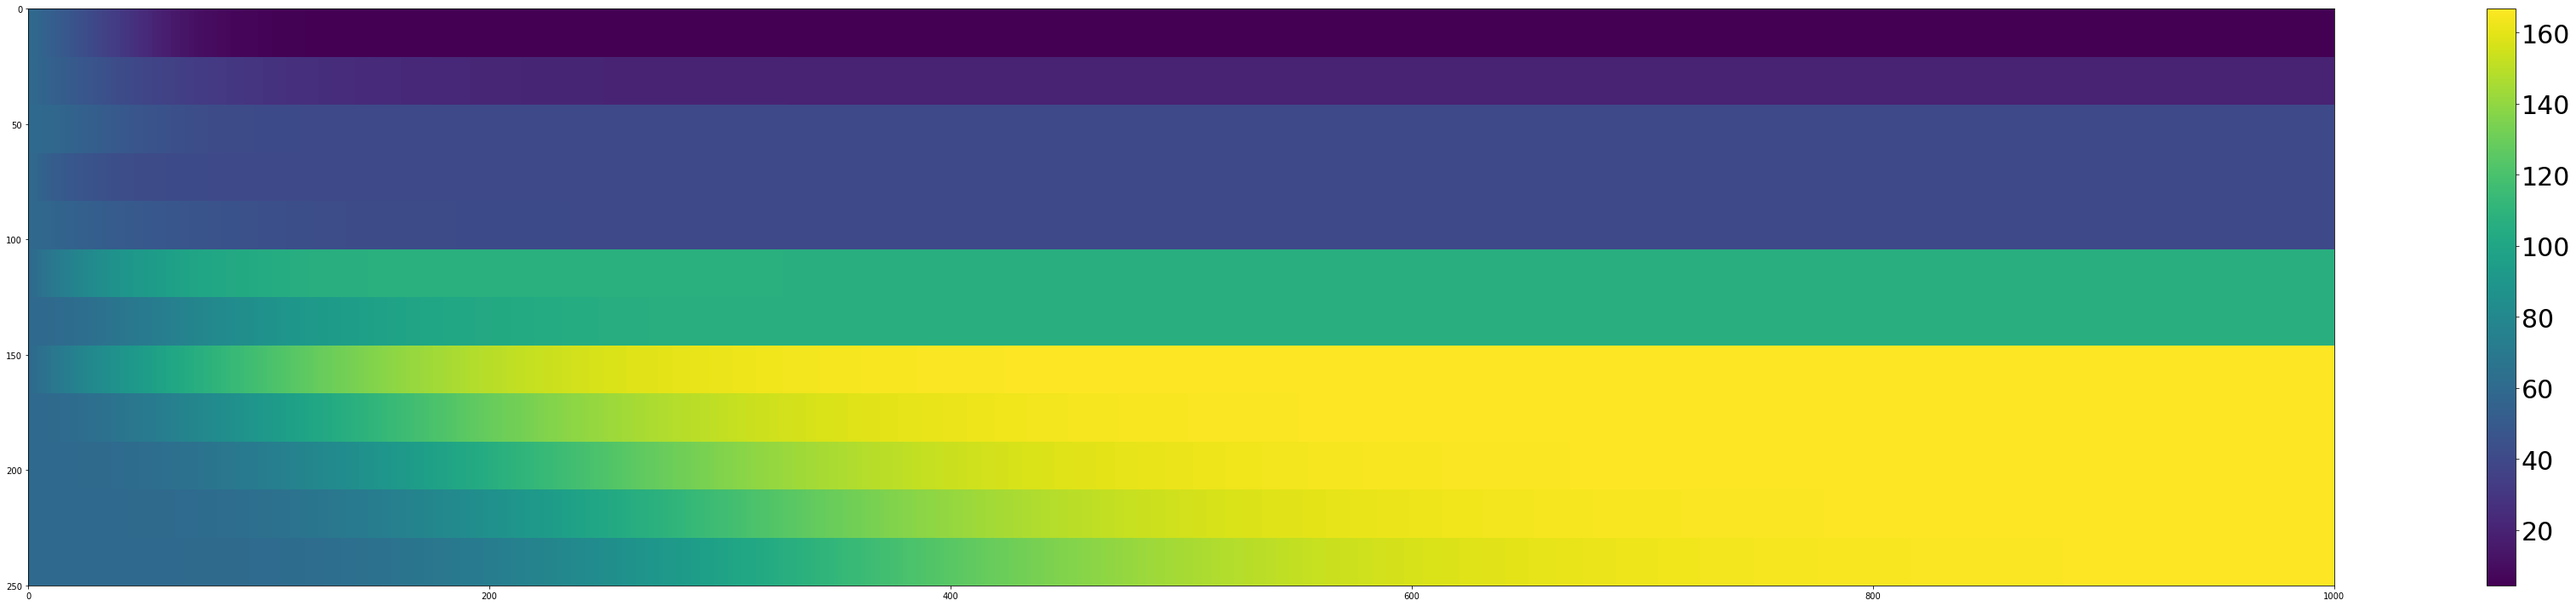

In [37]:
# Convert the list to a NumPy array
data_array = np.array(density_matrix)

plt.rcParams["figure.figsize"] = [50, 10]
plt.rcParams["figure.autolayout"] = True

# Create a plot with a colormap
plt.imshow(data_array, cmap='viridis', interpolation='nearest', extent=[0,1000,0,250])
plt.gca().invert_yaxis()
# Add a colorbar for reference
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)